# Episode 05d: Scoping of Proofs of concepts - Dynamic Programming

TODO

In Episode 03, some potential problem solving strategies or heuristics. Fitted out with the  classes improved in Episode 04, let's try to solve the problem.

In this Episode will be focuse on exploring different technologies and check whether it is useful for solving this problem.

We willmost of time focus on 2x2 simple problems and assume that we know a solution to the problem. The latter will simplify the problem by allowing to check if the proposed solution aquals the expected solution instead of verifying if the solution works.

**Goals for this episode:**
- Try to solve the puzzle with classes defined in Episode 04
- List potential strategies or heuristics
- Evaluate by solving simple 2x2 problem with a known solution

# TODO group by categories 
?
optimizers
machine learning - NLP /transformers


use only known solutions and 2x2 here

# 1. Some initialisations

In [2]:
from episode04.board import BoardMark
from episode04.gameengine import SolvedNonoGameEngine
from episode04.puzzle import Puzzle
from episode04.samples import clues2x2, clues5x5s, solution2x2, solution5x5s

import numpy as np

In [3]:
clues2x2

{'rows': [1, 2], 'cols': [2, 1]}

In [4]:
solution2x2

array([[1, 0],
       [1, 1]])

Now, let's loop over the problem space

# 5. Dynamic programming

Wikipedia defines constraint Programming as following: 
> Dynamic programming is both a mathematical optimization method and a computer programming method. The method was developed by Richard Bellman in the 1950s and has found applications in numerous fields, from aerospace engineering to economics.
>In both contexts it refers to simplifying a complicated problem by breaking it down into simpler sub-problems in a recursive manner. 

Implement often rely on recursion and reduce or fold method.
> In functional programming, fold (also termed reduce, accumulate, aggregate, compress, or inject) refers to a family of higher-order functions that analyze a recursive data structure and through use of a given combining operation, recombine the results of recursively processing its constituent parts, building up a return value. Typically, a fold is presented with a combining function, a top node of a data structure, and possibly some default values to be used under certain conditions. The fold then proceeds to combine elements of the data structure's hierarchy, using the function in a systematic way.  - Wikipedia

## 5.1. Simple exemple with a sum

Say we want to do the sum of 4 numbers [2, 4, 3, 1].

What is the subproblem ? 

Do the element of the list to the sum of the elements of the rest of the list. 

This process can be repeated for 3 and 2 numbers. It stops when there is no number in the list anymore.

This proxess is called folding or reduce. 
- Each step the problem is reduced, has less numbers. 
- The recursion create a tree of subproblem that will be unfolded and folded

In [5]:
# sum numbers
def fold(numbers, total):
    print(f"numbers:{numbers} - total:{total}")
    if len(numbers) == 0:
        return total
    return fold(numbers[1:], total+numbers[0])
    
total = fold([2, 4, 3, 1], 0)
total

numbers:[2, 4, 3, 1] - total:0
numbers:[4, 3, 1] - total:2
numbers:[3, 1] - total:6
numbers:[1] - total:9
numbers:[] - total:10


10

## 5.2. Application to he 2x2 board

I suggled a lot to define what is the problem and the subproblem. Is it the clues lists ? Is it the board states ?

What are the subproblems here ?

Let's say that the subproblem is 
```
10
1?
```
I must replace the ? by 0 or 1
- 0 would break the clues for row 1 (2 expected)
- 1 would hold the clue and solve the board

To go there I solved a simplier subproblem
```
10
?
```
I must replace the ? by 0 or 1
- 0 would break the clues because col 0 expects 2
- 1 would hold the clue for this subproblem

By filling the bard cell by cell, all the hypothesis could be explored and selected when they do not breal the clues.

Let's start by building a list of all possible boards.

In [8]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = SolvedNonoGameEngine(puzzle2x2, solution2x2, track=True)

In [6]:
# all boards
from math import floor
import copy
board_lenght = 4 # 2x2
def fold(cells):
    #print(f"cells:{cells}")
    if len(cells) == board_lenght:
        # found a board - will add to the list of boards
        return [cells]
    
    # boards built in this subproblem
    boards = []
    boards.extend(fold(cells + [0])) 
    boards.extend(fold(cells + [1])) 
    return boards

fold([])

[[0, 0, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [0, 1, 0, 0],
 [0, 1, 0, 1],
 [0, 1, 1, 0],
 [0, 1, 1, 1],
 [1, 0, 0, 0],
 [1, 0, 0, 1],
 [1, 0, 1, 0],
 [1, 0, 1, 1],
 [1, 1, 0, 0],
 [1, 1, 0, 1],
 [1, 1, 1, 0],
 [1, 1, 1, 1]]

In [21]:
# all boards matching the solution
from math import floor
import copy
board_lenght = 4 # 2x2
def fold(cells):
    #print(f"cells:{cells}")
    if len(cells) == board_lenght:
        n_errors = game2x2.submit(cells)
        if n_errors == 0:
            # found a board - will add to the list of boards
            return [cells]
        else:
            # drop - stop the folding bit does not add to the listt
            #print(f"drop {cells}")
            return []
   
    # boards built in this subproblem
    boards = []
    boards.extend(fold(cells + [0])) 
    boards.extend(fold(cells + [1])) 
    return boards

valid_boards = fold([])
valid_boards

[[1, 0, 1, 1]]

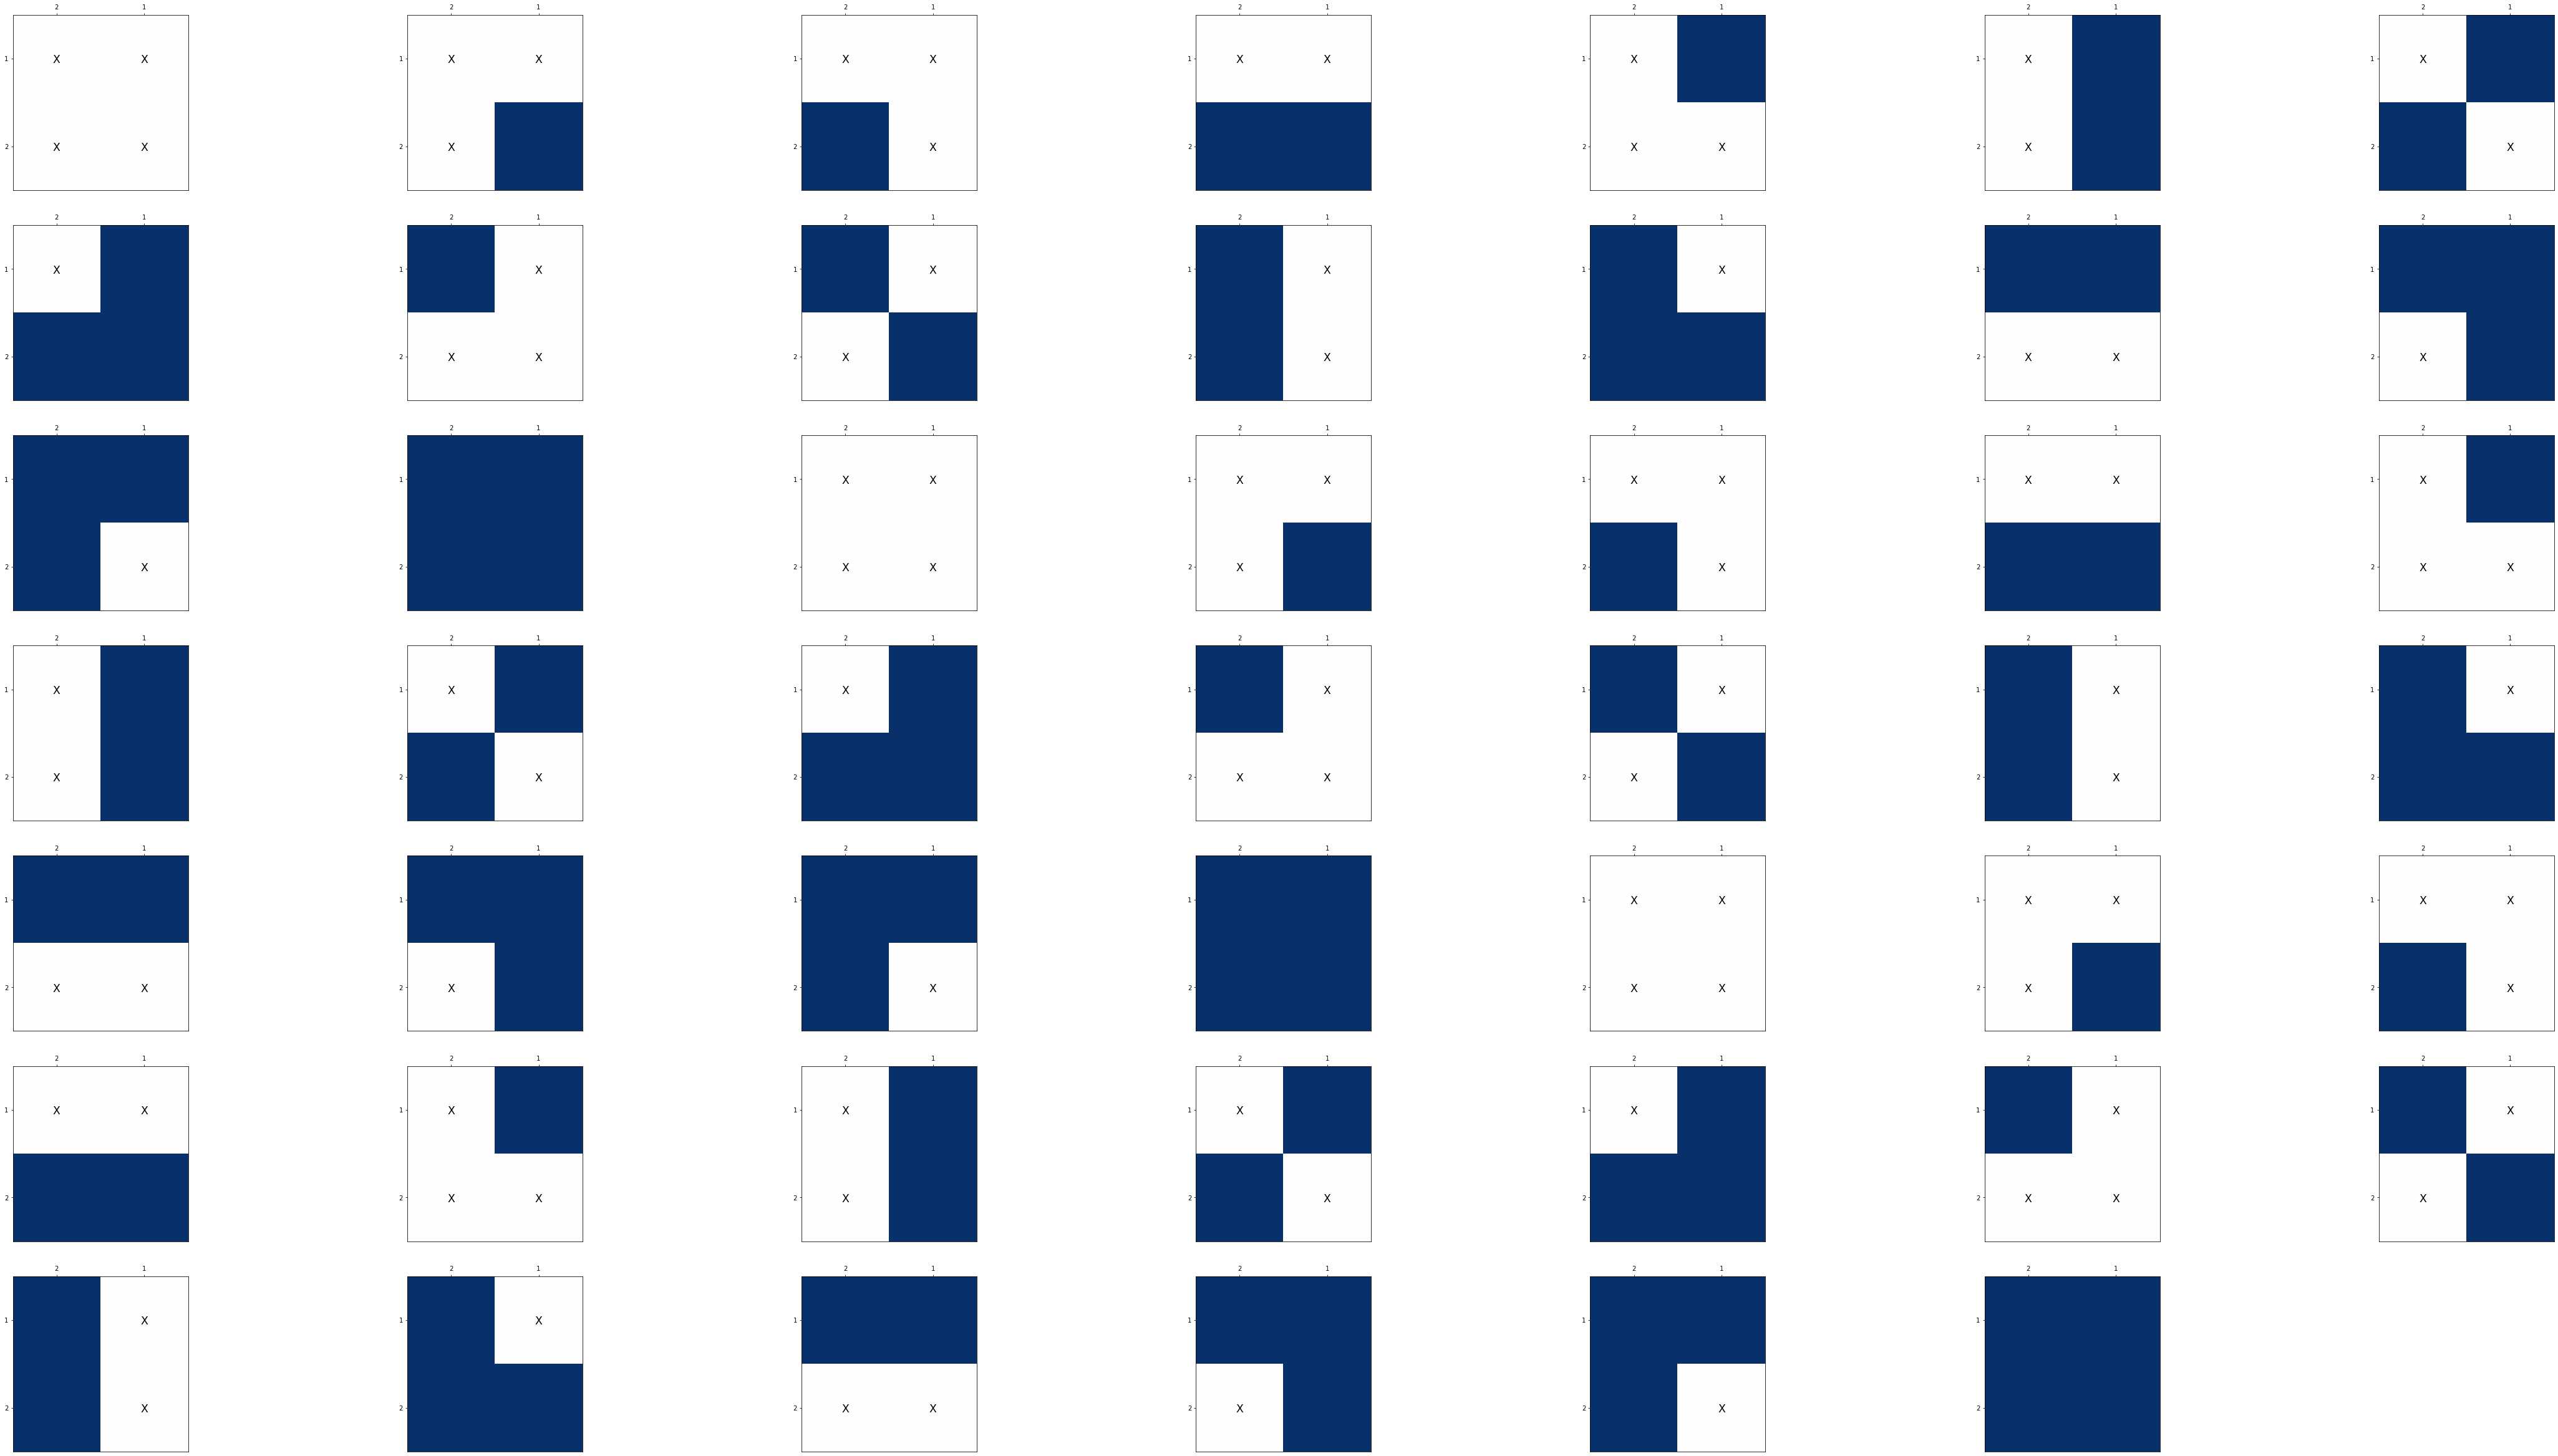

In [16]:
game2x2.show_all()

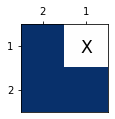

In [18]:
game2x2 = SolvedNonoGameEngine(puzzle2x2, solution2x2, track=True)
for board in valid_boards:
    game2x2.submit(board)

game2x2.show_all()

A better solution would to stop folding as soon as a clue is broken

In [20]:
# all boards matching the solution
from math import floor
import copy
board_lenght = 4 # 2x2
def fold(cells, pos, running_sum):
    if len(cells) == board_lenght:
        if running_sum['rows'] == clues2x2['rows'] and running_sum['cols'] == clues2x2['cols']:
            # found a board - will add to the list of boards
            return [cells]
        else:
            # drop - stop the folding but does not add to the listt
            #print(f"drop {cells}")
            return []

    row = floor(pos/2)
    col = pos%2
    #print(f"cells:{cells} - pos:{pos} - row:{row} - col:{col} - running_sum:{running_sum}")
    
    if running_sum['rows'][row] > clues2x2['rows'][row]:
        #print(f"drop {cells}")
        return [] # drop - clue is broken
    
    if running_sum['cols'][col] > clues2x2['cols'][col]:
        #print(f"drop {cells}")
        return [] # drop - clue is broken 

    # boards built in this subproblem
    boards = []
    # 0 do not alter the sum
    boards.extend(fold(cells + [0], pos+1, running_sum))
    # 1 will be added to the running_sum
    # need a different dict otherwize reference is modified
    new_running_sum = copy.deepcopy(running_sum)
    new_running_sum['rows'][row] += 1
    new_running_sum['cols'][col] += 1
    boards.extend(fold(cells + [1], pos+1, new_running_sum))
    return boards

valid_boards = fold([], 0, {'rows':[0,0], 'cols':[0,0]}, )
valid_boards

[[1, 0, 1, 1]]

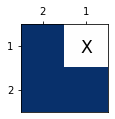

In [22]:
game2x2 = SolvedNonoGameEngine(puzzle2x2, solution2x2, track=True)
for board in valid_boards:
    game2x2.submit(board)

game2x2.show_all()

## 5.3. Wrap up

It is the ost classical way of solving problem.

What works:
- Any complex contraint can be implemented in the fold function

Limitation:
- Code is a bit tricky as it comes to managing a tre of solutions

The main idea is implemented. Need some improvement to run sum with split block and tests against the 5x5s game


- Ideation: 30mn - classical paradigm 
- Design: 4h - for whatever reason I could not feature out what the problem is and that I don,ot need to validate the rule on subproblem, only prune folds where the rule are broken (when sum is over the clue). My first go was that the subproblem were each element of the clue
- Implementation: 3h - a bit tricly to solve the list of list, then the running sum